In [2916]:

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.impute import KNNImputer
from manager import manager
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import statsmodels.api as sm
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

%pip install fast_ml --upgrade

from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features


Note: you may need to restart the kernel to use updated packages.


Caricamento di Train-test e Test-set

In [2917]:
trainset = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
lenght_trainset = trainset.shape
#print(lenght_trainset)
#lenght
trainset.head(10)
testset = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")
lenght_testset = testset.shape
#print(lenght_testset)
#testset

L'idea adesso è vedere quali features nel testset non sono presenti nel trainset e viceversa, essendo la dimensione delle colonne diversa

In [2918]:
#check if every feature in trainset is also present in testset and viceversa
notInTestset = []
notInTrainset = []
for x in trainset.columns:
    if not testset.columns.__contains__(x):
        notInTestset.append(x)
print(f"Columns in trainset but not in testset: {notInTestset} \n")
for x in testset.columns:
    if not trainset.columns.__contains__(x):
        notInTrainset.append(x)
print(f"Columns in testset but not in trainset: {notInTrainset} \n")
        


Columns in trainset but not in testset: ['SalePrice'] 

Columns in testset but not in trainset: [] 



In [2919]:
#info of trainset
trainset_info = trainset.info()
print(trainset_info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [2920]:
#info of testset
testset_info = testset.info()
print(testset_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

eliminazione della feature id perchè non rilevante 

In [2921]:
#delete feature "ID" from trainset beacause it is not relevant
if "Id" in trainset.columns:
    trainset.drop(["Id"], axis="columns", inplace=True)

#delete feature "ID" from testset and save it
if "Id" in testset.columns:
    idList = testset['Id'].tolist()
    testset.drop(['Id'], axis="columns", inplace=True)
print(trainset.shape)
    

(1460, 80)


divisione di trainset e target

In [2922]:
target = trainset.iloc[:, len(trainset.columns)-1]
target.head(10)
trainset.drop(target.name, axis="columns", inplace=True)
trainset.head(10)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


eliminazione delle righe con più del 50% di valori nan

In [2923]:
nanPercInARow = []
for index, row in trainset.iterrows():
    nanPercInARow = trainset.loc[[index]].isna().sum().sum() / len(trainset.columns)
    if nanPercInARow > 0.5:
        trainset.drop(index, axis="rows", inplace=True)
print(len(trainset))


1460


Parsing del dataset.
features numeriche
features categoriche.

In [2924]:
#parsing trainset
print(trainset.shape)
trainset_num = trainset.select_dtypes(include=[np.number])
trainset_cat = trainset.select_dtypes(exclude=[np.number])



#parsing testset
testset_num = testset.select_dtypes(include=[np.number])
testset_cat = testset.select_dtypes(exclude=[np.number])
#print(trainset_cat.columns)
#print(trainset_num.columns)
print(trainset_num.shape)
print(trainset_cat.shape)

(1460, 79)
(1460, 36)
(1460, 43)


rimozione delle colonne con più del 95% di valori uguali.

In [2925]:
#constant_features = get_constant_features(trainset, threshold=0.95, dropna=False)
#constant_features.head(10)
#quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
#trainset.drop(columns = quasi_constant_features_list, inplace=True)
qconstant_filter = VarianceThreshold(threshold=0.05)
qconstant_filter.fit(trainset_num)
len(trainset_num.columns[qconstant_filter.get_support()])
qconstant_columns = [column for column in trainset_num.columns
                    if column not in trainset_num.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

for column in qconstant_columns:
    print(column)
    trainset_num.drop(column, axis="columns", inplace=True)
    testset_num.drop(column,axis="columns", inplace=True)  
    
trainset_num.shape


1
KitchenAbvGr


(1460, 35)

abbiamo 36 variabili numeriche indipendenti nel testset_num

gestione dei nan: utilizzo di knn

In [2926]:
#nan management
trainset_num.isna().sum()
#use knn
imputer = KNNImputer(n_neighbors=1, weights="uniform")
trainset_num_imputed = trainset_num
testset_num_imputed = testset_num
trainset_num_imputed = pd.DataFrame(imputer.fit_transform(trainset_num))
trainset_num_imputed.columns = trainset_num.columns
testset_num_imputed = pd.DataFrame(imputer.fit_transform(testset_num))
testset_num_imputed.columns = testset_num.columns



In [2927]:
#trainset_num.isna().sum()
print(trainset_num_imputed.shape)
print(testset_num_imputed.shape)
print(trainset_num_imputed.columns)

(1460, 35)
(1459, 35)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


correlazione

In [2928]:
trainset_num_conc =pd.concat([trainset_num_imputed, target], axis="columns")
correlation_matrix = trainset_num_conc.corr()

plt.figure(figsize=(15, 16), dpi=160)
#sns.heatmap(correlation_matrix, cmap="bwr")
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "10pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '80px'),
                        ('font-size', '10pt')])
]

correlation_matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '40px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.00,-0.35,-0.14,0.03,-0.06,0.03,0.04,0.03,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.04,-0.05,0.07,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.35,1.00,0.38,0.20,-0.04,0.09,0.05,0.16,0.22,0.08,0.09,0.35,0.41,0.09,0.03,0.38,0.09,0.03,0.19,0.06,0.26,0.32,0.24,0.05,0.25,0.31,0.10,0.12,0.04,0.06,0.06,0.14,0.01,0.02,0.02,0.32
LotArea,-0.14,0.38,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,0.19,0.27,-0.01,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,0.03,0.20,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,0.43,0.40,0.54,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,-0.06,-0.04,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.06,-0.02,-0.30,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,0.03,0.09,0.01,0.57,-0.38,1.00,0.59,0.31,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,0.10,0.15,0.80,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,0.04,0.05,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,0.19,0.11,0.61,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,0.03,0.16,0.10,0.41,-0.13,0.31,0.18,1.00,0.27,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.09,0.03,0.27,0.20,0.10,0.28,0.25,0.26,0.36,0.37,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.00,-0.01,0.48
BsmtFinSF1,-0.07,0.22,0.21,0.24,-0.05,0.25,0.13,0.27,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,0.04,0.26,0.16,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39
BsmtFinSF2,-0.07,0.08,0.11,-0.06,0.04,-0.05,-0.07,-0.07,-0.05,1.00,-0.21,0.10,0.10,-0.10,0.01,-0.01,0.16,0.07,-0.08,-0.03,-0.02,-0.04,0.05,-0.07,-0.04,-0.02,0.07,0.00,0.04,-0.03,0.09,0.04,0.00,-0.02,0.03,-0.01


<Figure size 2400x2560 with 0 Axes>

analisi della correlazione con "SalePrice"
• se |corr|>0.80 strong correlation
• se 0.5<|corr|<0.80 moderate correlation
• se 0.20<|corr|<0.5 weak correlation
• se |corr|<0.2 very weak or null correlation

In [2929]:
target_correlation = trainset_num_conc.corr()[target.name][:-1]
target_correlation

MSSubClass      -0.084284
LotFrontage      0.316983
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.475611
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.492040
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
Name: SalePrice, dtype: float64

In [2930]:
#find features with a very weak correlations 
very_weak_corr = target_correlation[abs(target_correlation)<0.25].sort_values(ascending=False)
#print something
very_weak_corr_names = target_correlation[abs(target_correlation)<0.25].index.tolist()
#print(very_weak_corr_names)

#find features with a weak correlations
weak_corr = target_correlation[(abs(target_correlation)>=0.25) & (abs(target_correlation)<0.50)].sort_values(ascending=False)
#print something
weak_corr_list = target_correlation[(abs(target_correlation)>=0.25) & (abs(target_correlation)<0.50)].index.tolist()

#find features with a moderate correlations
moderate_corr = target_correlation[(abs(target_correlation)>=0.50) & (abs(target_correlation)<0.75)].sort_values(ascending=False)
moderate_corr_list = target_correlation[(abs(target_correlation)>=0.50) & (abs(target_correlation)<0.75)].index.tolist()
#print(moderate_corr)

#find features with a strong correlations
strong_corr = target_correlation[(abs(target_correlation)>=0.75)].sort_values(ascending=False)
strong_corr_list = target_correlation[(abs(target_correlation)>=0.75)].index.tolist()
#print(strong_corr)



In [2931]:
#trainset and testset with only correlated feature
trainset_num_corr = trainset_num_conc.loc[:, strong_corr_list + moderate_corr_list + weak_corr_list + [target.name]]
testset_num_corr = testset_num_imputed.loc[:, strong_corr_list + moderate_corr_list + weak_corr_list]

print(trainset_num_corr.shape)
print(testset_num_corr.shape)

trainset_num_corr.head(10)


(1460, 21)
(1459, 20)


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,...,LotArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,HalfBath,Fireplaces,GarageYrBlt,WoodDeckSF,OpenPorchSF,SalePrice
0,7.0,2003.0,2003.0,856.0,856.0,1710.0,2.0,8.0,2.0,548.0,...,8450.0,196.0,706.0,854.0,1.0,0.0,2003.0,0.0,61.0,208500
1,6.0,1976.0,1976.0,1262.0,1262.0,1262.0,2.0,6.0,2.0,460.0,...,9600.0,0.0,978.0,0.0,0.0,1.0,1976.0,298.0,0.0,181500
2,7.0,2001.0,2002.0,920.0,920.0,1786.0,2.0,6.0,2.0,608.0,...,11250.0,162.0,486.0,866.0,1.0,1.0,2001.0,0.0,42.0,223500
3,7.0,1915.0,1970.0,756.0,961.0,1717.0,1.0,7.0,3.0,642.0,...,9550.0,0.0,216.0,756.0,0.0,1.0,1998.0,0.0,35.0,140000
4,8.0,2000.0,2000.0,1145.0,1145.0,2198.0,2.0,9.0,3.0,836.0,...,14260.0,350.0,655.0,1053.0,1.0,1.0,2000.0,192.0,84.0,250000
5,5.0,1993.0,1995.0,796.0,796.0,1362.0,1.0,5.0,2.0,480.0,...,14115.0,0.0,732.0,566.0,1.0,0.0,1993.0,40.0,30.0,143000
6,8.0,2004.0,2005.0,1686.0,1694.0,1694.0,2.0,7.0,2.0,636.0,...,10084.0,186.0,1369.0,0.0,0.0,1.0,2004.0,255.0,57.0,307000
7,7.0,1973.0,1973.0,1107.0,1107.0,2090.0,2.0,7.0,2.0,484.0,...,10382.0,240.0,859.0,983.0,1.0,2.0,1973.0,235.0,204.0,200000
8,7.0,1931.0,1950.0,952.0,1022.0,1774.0,2.0,8.0,2.0,468.0,...,6120.0,0.0,0.0,752.0,0.0,2.0,1931.0,90.0,0.0,129900
9,5.0,1939.0,1950.0,991.0,1077.0,1077.0,1.0,5.0,1.0,205.0,...,7420.0,0.0,851.0,0.0,0.0,2.0,1939.0,0.0,4.0,118000


ouliers detection univariata

In [2932]:
def detect_outliers_zscore(data):
    thres = 3
    outliers = []
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code

print("{:<30}{:<20}".format("Feature", "Percentage of ouliers"))
percentageOutliers = []
for col in trainset_num_corr.columns[:-1]:   
    sample_outliers = detect_outliers_zscore(trainset_num_corr.iloc[:][col])
    percentageOutliers.append((len(sample_outliers)/len(trainset_num_corr))*100)
    print("{:<30}{:<20}".format(col, str((len(sample_outliers)/len(trainset_num_corr))*100)) + " %")
    
print("Max Percentage: " + str(max(percentageOutliers))+ " %")
    
    

Feature                       Percentage of ouliers
OverallQual                   0.136986301369863    %
YearBuilt                     0.410958904109589    %
YearRemodAdd                  0.0                  %
TotalBsmtSF                   0.684931506849315    %
1stFlrSF                      0.821917808219178    %
GrLivArea                     1.095890410958904    %
FullBath                      0.0                  %
TotRmsAbvGrd                  0.821917808219178    %
GarageCars                    0.0                  %
GarageArea                    0.4794520547945206   %
LotFrontage                   1.095890410958904    %
LotArea                       0.8904109589041096   %
MasVnrArea                    2.191780821917808    %
BsmtFinSF1                    0.410958904109589    %
2ndFlrSF                      0.273972602739726    %
HalfBath                      0.821917808219178    %
Fireplaces                    0.3424657534246575   %
GarageYrBlt                   0.068493150684931

plot delle feature. check normality by plotting a frequency distribution, also called a histogram, of the data and visually comparing it to a normal distribution

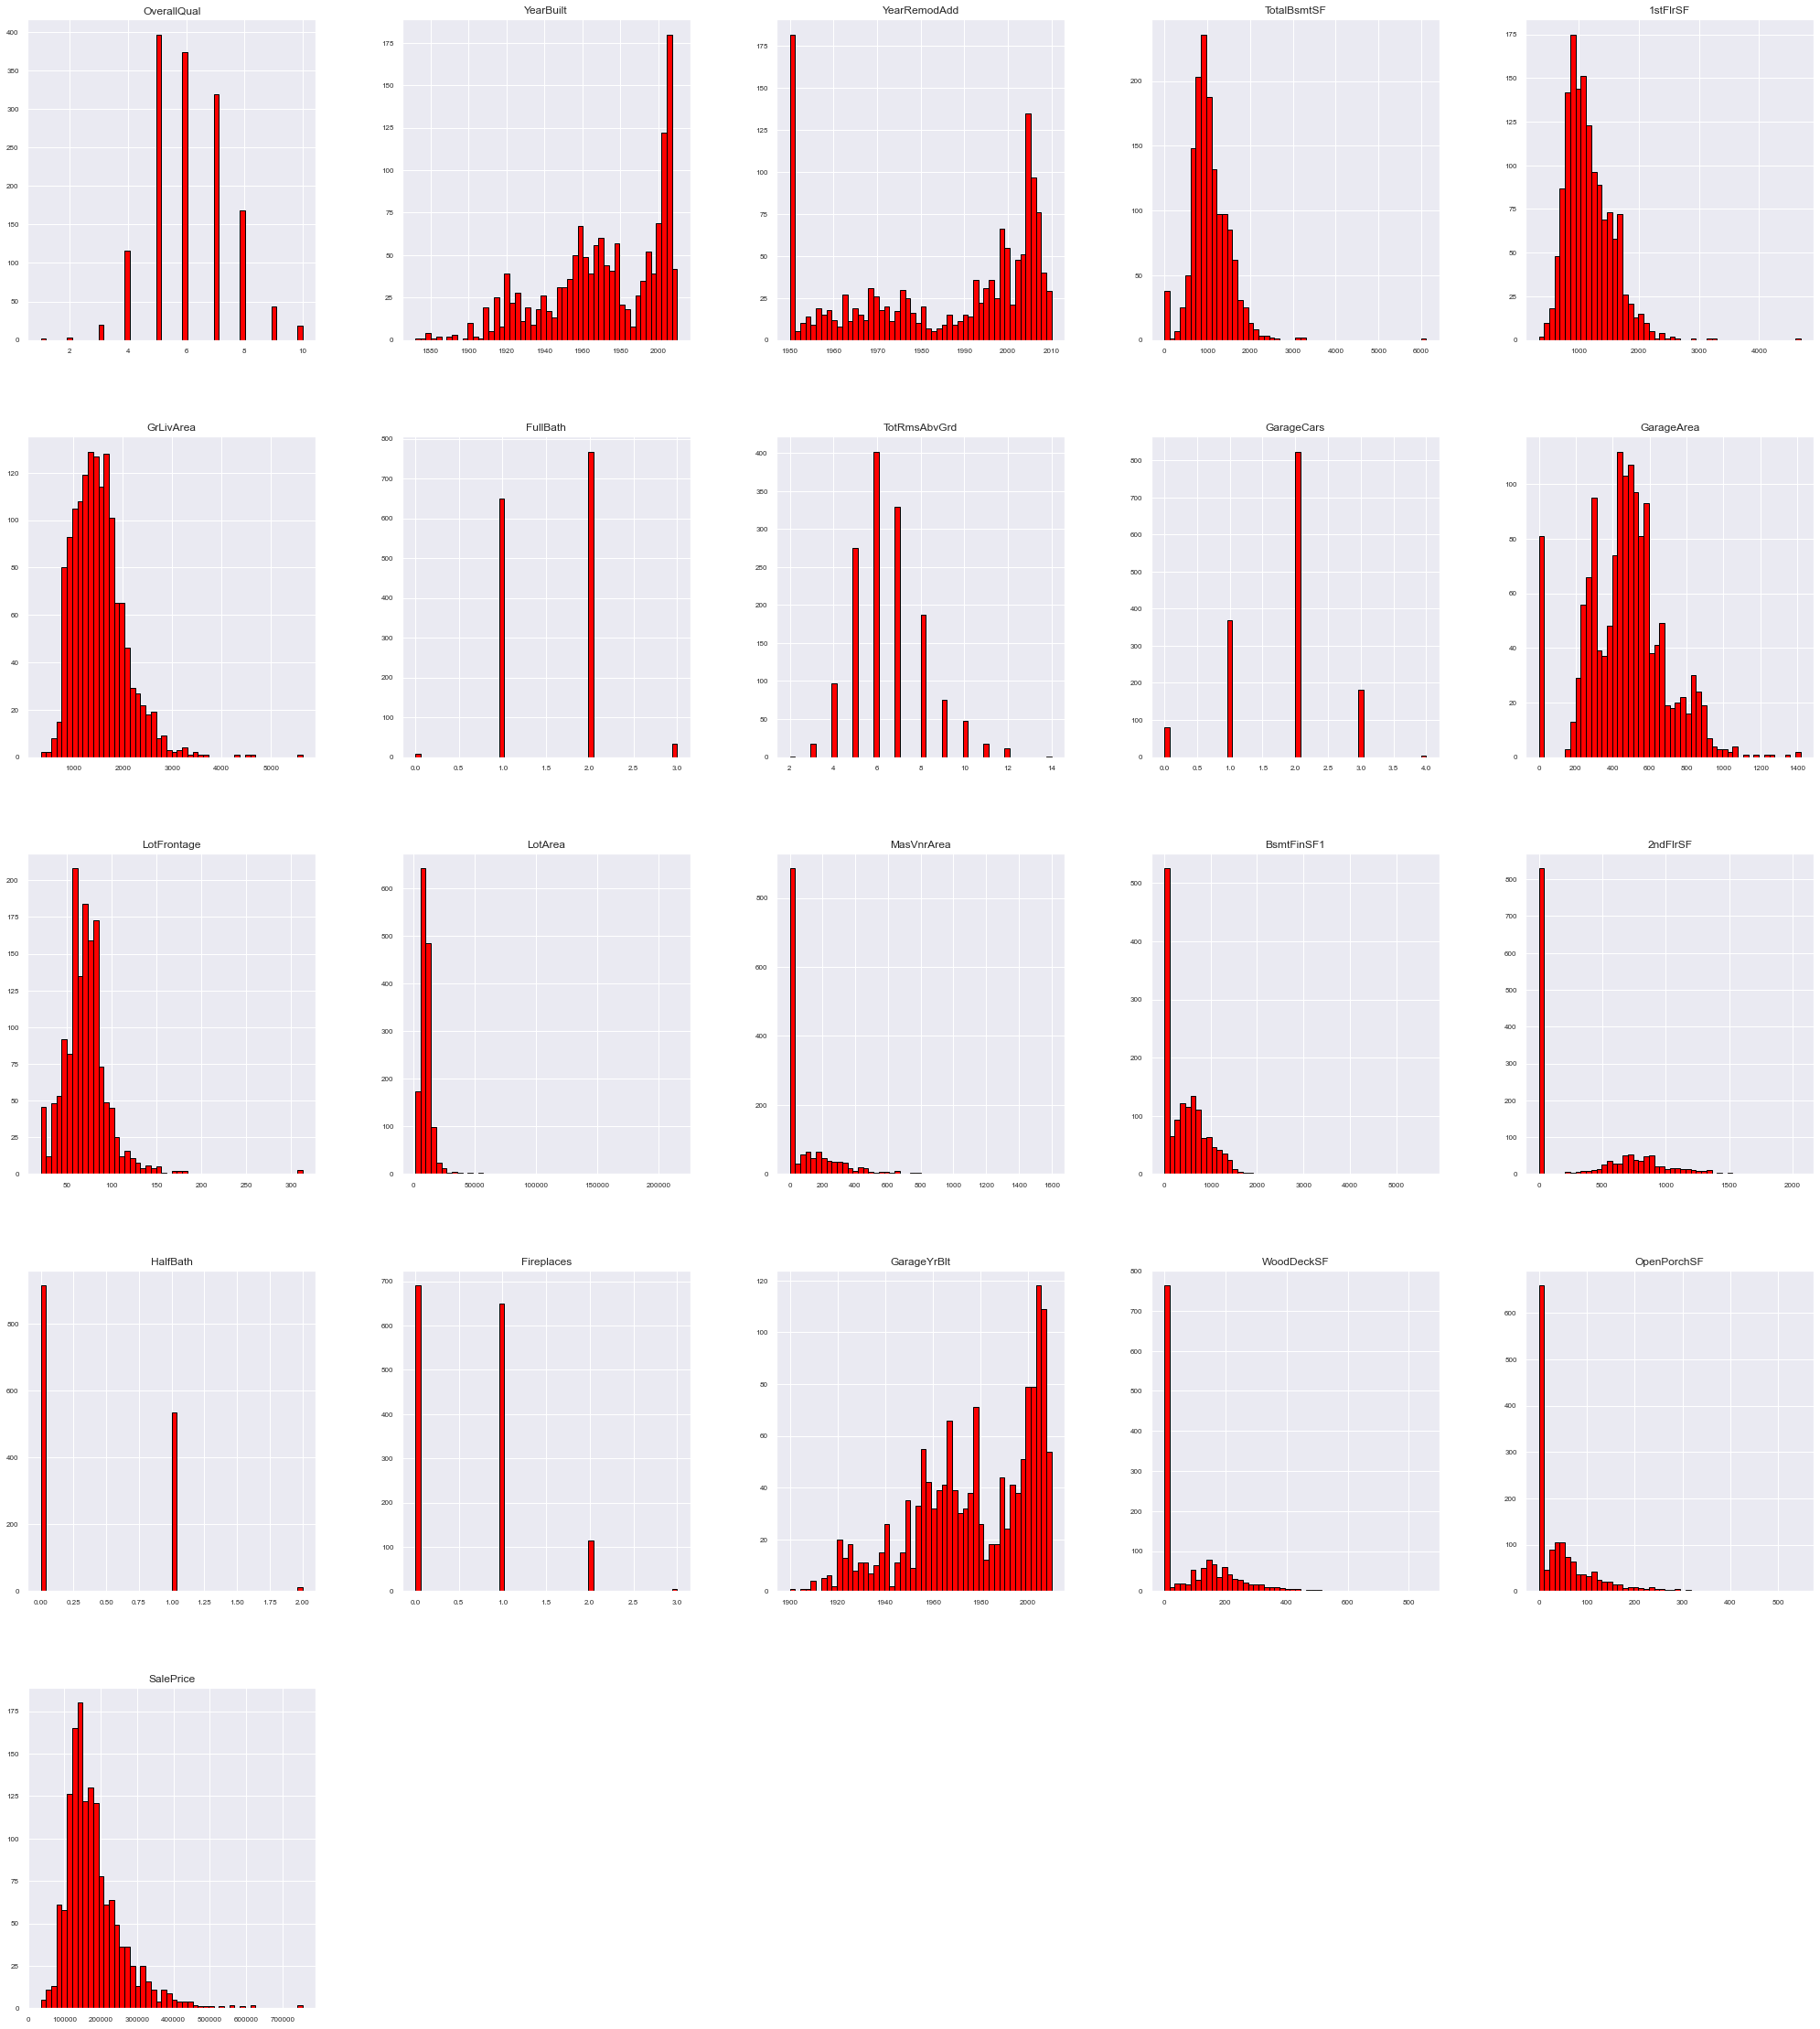

In [2933]:
plot = trainset_num_corr.hist(figsize=(35,40), bins=50, color="red", edgecolor="black", xlabelsize=8, ylabelsize=8)
    

dai grafici si può notare che non tutte le feature hanno una distribuzione normale, di conseguenza è meglio utilizzare l'Inter Quantile Range (IQR) rule per il rilevamento degli outlier

In [2934]:

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code


print("Outliers from IQR method: ", sample_outliers)


print("{:<30}{:<20}".format("Feature", "Percentage of ouliers"))
percentageOutliers = []
for col in trainset_num_corr.columns[:-1]:   
    sample_outliers = detect_outliers_iqr(trainset_num_corr.iloc[:][col])
    percentageOutliers.append((len(sample_outliers)/len(trainset_num_corr))*100)
    print("{:<30}{:<20}".format(col, str((len(sample_outliers)/len(trainset_num_corr))*100)) + " %")
    
print("Max Percentage: " + str(max(percentageOutliers))+ " %")

Outliers from IQR method:  [258.0, 260.0, 250.0, 523.0, 285.0, 406.0, 502.0, 274.0, 312.0, 267.0, 265.0, 288.0, 341.0, 247.0, 291.0, 312.0, 418.0, 364.0, 252.0, 282.0, 319.0, 263.0, 304.0, 287.0, 292.0, 547.0, 262.0]
Feature                       Percentage of ouliers
OverallQual                   0.136986301369863    %
YearBuilt                     0.4794520547945206   %
YearRemodAdd                  0.0                  %
TotalBsmtSF                   4.178082191780822    %
1stFlrSF                      1.36986301369863     %
GrLivArea                     2.1232876712328768   %
FullBath                      0.0                  %
TotRmsAbvGrd                  2.054794520547945    %
GarageCars                    0.3424657534246575   %
GarageArea                    1.4383561643835616   %
LotFrontage                   7.739726027397261    %
LotArea                       4.726027397260274    %
MasVnrArea                    6.6438356164383565   %
BsmtFinSF1                    0.4794520547

studio delle Categorical features

43


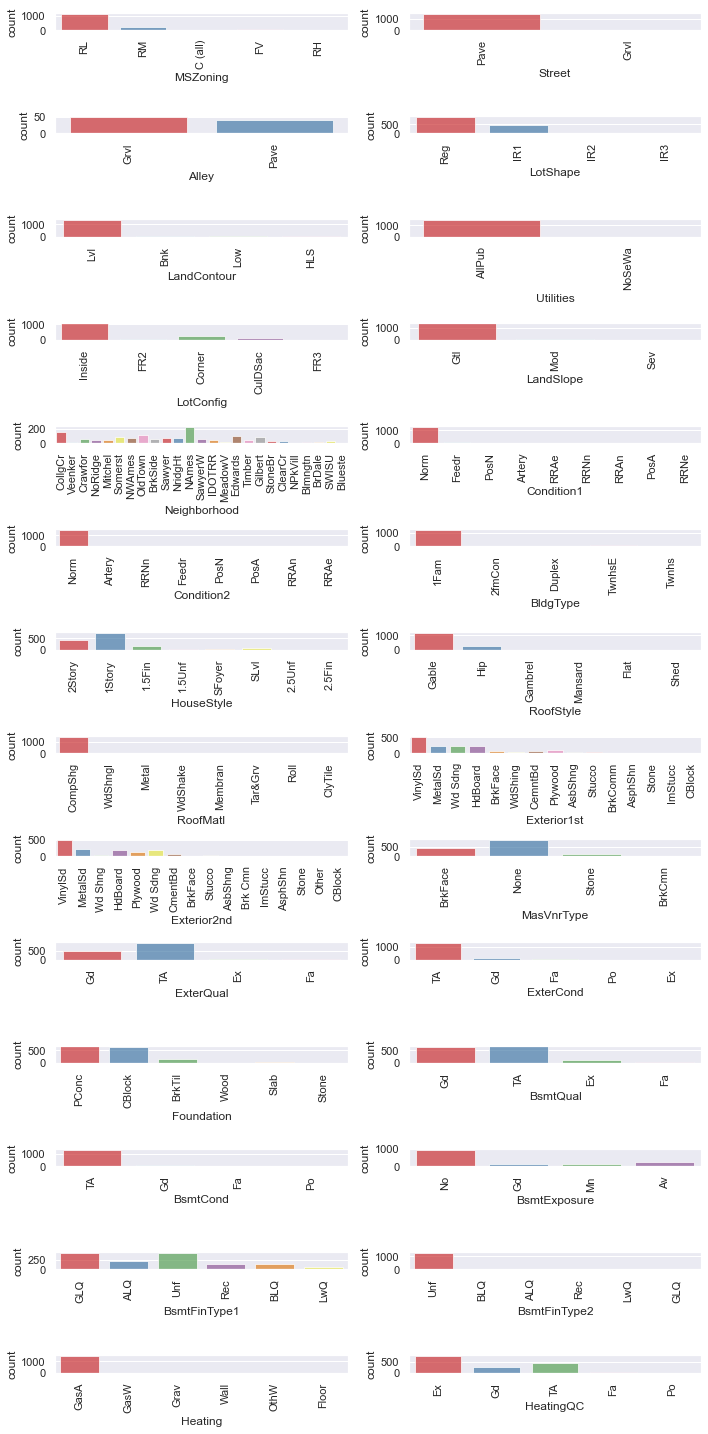

In [2935]:
#check di ogni colonna, elimino le colonne che hanno tutti i valori uguali
print(len(trainset_cat.columns))
fig, axes = plt.subplots(round(len(trainset_cat.columns)/3 ), 2, figsize=(10, 20))


for i, axis in enumerate(fig.axes):
        if i < len(trainset_cat.columns)-1:
            
            axis.set_xticklabels(axis.xaxis.get_majorticklabels(), rotation=90)
            sns.countplot(x=trainset_cat.columns[i], alpha=0.7, data=trainset_cat, ax=axis, palette="Set1")
            
fig.tight_layout()
            

eliminazione di feature costanti

In [2936]:
constant_features = get_constant_features(trainset_cat, threshold=0.95, dropna=False)
print(constant_features)
quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
print(quasi_constant_features_list)
print(trainset_cat.columns)
print(trainset_cat.shape)
trainset_cat_filt = trainset_cat.drop(quasi_constant_features_list, axis="columns", inplace=False)
testset_cat_filt = testset_cat.drop(quasi_constant_features_list, axis="columns", inplace=False)
print(trainset_cat.shape)
    

             Desc          Var    Value       Perc
0  Quasi Constant    Utilities   AllPub  99.931507
1  Quasi Constant       Street     Pave  99.589041
2  Quasi Constant       PoolQC      NaN  99.520548
3  Quasi Constant   Condition2     Norm  98.972603
4  Quasi Constant     RoofMatl  CompShg  98.219178
5  Quasi Constant      Heating     GasA  97.808219
6  Quasi Constant  MiscFeature      NaN  96.301370
['Utilities', 'Street', 'PoolQC', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature']
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType',

Gestione dei nan in trainset_cat

In [2937]:
print(len(trainset_cat_filt.columns))
columnsWithHighPercOfNan = []
for col in trainset_cat_filt.columns:
    if trainset_cat_filt[col].isna().sum() >= len(trainset_cat)*0.40:
        columnsWithHighPercOfNan.append(col)

print("Columns with high percentage of NaN to drop: ")
print(columnsWithHighPercOfNan)

trainset_cat_filt.drop(columnsWithHighPercOfNan, axis="columns", inplace=True)
testset_cat_filt.drop(columnsWithHighPercOfNan, axis="columns", inplace=True)

trainset_cat_filt.columns

36
Columns with high percentage of NaN to drop: 
['Alley', 'FireplaceQu', 'Fence']


Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

riempimento dei nan

In [2938]:
for col in testset_cat_filt.columns:
    
    if trainset_cat_filt[col].isna().sum() > 0:
        print(col + " number of nan= " + str(trainset_cat_filt[col].isna().sum()))
        categ_fill_null = {col: trainset_cat_filt[col].mode().iloc[0]}
        trainset_cat_filt = trainset_cat_filt.fillna(value=categ_fill_null)        
    
       




MasVnrType number of nan= 8
BsmtQual number of nan= 37
BsmtCond number of nan= 37
BsmtExposure number of nan= 38
BsmtFinType1 number of nan= 37
BsmtFinType2 number of nan= 38
Electrical number of nan= 1
GarageType number of nan= 81
GarageFinish number of nan= 81
GarageQual number of nan= 81
GarageCond number of nan= 81


data exploration manuale del trainset_cat

In [2939]:
print(trainset_cat_filt.columns)

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


encoding categorical features

In [2940]:
#encoding trainset
featureToEncode = []
lastTrainsetIndex = len(trainset_cat_filt)
df_cat = pd.concat([trainset_cat_filt, testset_cat_filt], axis="rows")
#print(lastTrainsetIndex)
#print(trainset_cat.shape)
#print(testset_cat.shape)
#print(trainset_cat_filt.head)
for col in df_cat.columns:
    featureToEncode.append(col)
    #print(str(col)+ "\n")
    #print(trainset_cat[col].unique())
    #trainset_cat[col] = trainset_cat[col].astype['category']

le = LabelEncoder()
for col in df_cat.select_dtypes(include='O').columns:
    #df_cat[col]=le.fit_transform(df_cat[col])
    df_cat_dummies = pd.get_dummies(df_cat)
#encoder = OneHotEncoder(drop="first")

#df_cat_encoded = encoder.fit_transform(df_cat)
#df_cat = pd.DataFrame(df_cat_encoded.toarray(), columns=encoder.get_feature_names(), index=df_cat.index)

#split del df_cat in trainset_cat e testset_cat dopo l'encoding

trainset_cat_encoded = df_cat_dummies.iloc[:lastTrainsetIndex , :]
testset_cat_encoded = df_cat_dummies.iloc[lastTrainsetIndex: , :]

#concatenazione di trainset_num e trainset_cat dopo l'encoding
print(trainset_cat_encoded.head(10))

#trainset = pd.concat([trainset_num, trainset_cat], axis="columns")


#concatenazione di trainset_num e trainset_cat dopo l'encoding

#testset = pd.concat([testset_num, testset_cat], axis="columns")


print(trainset_cat_encoded.shape)
print(testset_cat_encoded.shape)






   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   
5                 0            0            0            1            0   
6                 0            0            0            1            0   
7                 0            0            0            1            0   
8                 0            0            0            0            1   
9                 0            0            0            1            0   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  \
0             0             0             0             1                0   
1             0   

PreProcessamento: feature engeneering

In [2941]:
new_trainset = pd.concat([trainset_num_corr, trainset_cat_encoded], axis="columns")
new_testset = pd.concat([testset_num_corr, testset_cat_encoded], axis="columns")

print(new_trainset.shape)
print(new_testset.shape)



(1460, 229)
(1459, 228)


In [2942]:
# Convert Year of construction to the Age of the house since the construction
lastYear = max(new_trainset["YearBuilt"].max(), new_trainset["YearRemodAdd"].max())
#print(lastYear)

new_trainset["AgeSinceConst"] = (lastYear - new_trainset["YearBuilt"])
new_testset["AgeSinceConst"] = (lastYear - new_testset["YearBuilt"])

# Drop "YearBuilt"
new_trainset.drop(["YearBuilt"], axis=1, inplace=True)
new_testset.drop(["YearBuilt"], axis=1, inplace=True)

# Convert Year of remodeling to the Age of the house since the remodeling
new_trainset["AgeSinceRemod"] = (lastYear - new_trainset["YearRemodAdd"])
new_testset["AgeSinceRemod"] = (lastYear - new_testset["YearRemodAdd"])

# Drop "YearRemodAdd"
new_trainset.drop(["YearRemodAdd"], axis=1, inplace=True)
new_testset.drop(["YearRemodAdd"], axis=1, inplace=True)
new_trainset.shape

(1460, 229)

log trasformation

In [2943]:
continuous_features = ["OverallQual", "TotalBsmtSF", "GrLivArea",
                       "FullBath", "GarageArea","MasVnrArea", "Fireplaces", "AgeSinceConst", "AgeSinceRemod"]
df_skew_verify = new_trainset.loc[:, continuous_features]
df_skew_verify.head()

df_skew_verify = new_trainset.loc[:, continuous_features]

# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame({"Columns": continuous_features, "Abs_Skew": skew_ft})


sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")


# Log transformation of the skewed features
for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Training set
    new_trainset[i] = np.log((new_trainset[i])+1)
    
    # Test set
    new_trainset[i] = np.log((new_trainset[i])+1)
    
    
# Log transformation of the target variable "SalePrice"
new_trainset["SalePriceLog"] = np.log(new_trainset.SalePrice)

# Drop the original SalePrice
new_trainset.drop(["SalePrice"], axis=1, inplace=True)

List of skewed features: ['TotalBsmtSF', 'GrLivArea', 'MasVnrArea', 'Fireplaces', 'AgeSinceConst', 'AgeSinceRemod']


split dati e scaling

In [2944]:
bins = np.linspace(0, len(target), 150)
X = new_trainset[[i for i in list(
    new_trainset.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)

y = new_trainset.loc[:, "SalePriceLog"]
    
print(X.shape)
print(y)

y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned, shuffle=True)
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
new_testset = std_scale.transform(new_testset)

# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
print(X_train.shape)
X_test = pd.DataFrame(X_test, columns=X.columns)
new_testset = pd.DataFrame(new_testset, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

(1460, 228)
(1460, 228)
0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePriceLog, Length: 1460, dtype: float64
(1168, 228)


selected feature

In [2945]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")
    
    
backward_regression(X_train, y_train)

worst_feature : SaleCondition_Alloca, 0.9924365596602169 
worst_feature : Exterior2nd_Other, 0.9897227480160453 
worst_feature : Exterior2nd_HdBoard, 0.9849770587416584 
worst_feature : Exterior1st_WdShing, 0.979525876459276 
worst_feature : GarageQual_TA, 0.9718235144652411 
worst_feature : LandSlope_Gtl, 0.9633316779993187 
worst_feature : ExterCond_Po, 0.9968303046851008 
worst_feature : SaleType_Con, 0.9631128532554287 
worst_feature : BsmtFinType2_Rec, 0.9613970705294596 
worst_feature : BsmtFinType2_Unf, 0.9743601814378154 
worst_feature : ExterQual_Gd, 0.9485267822576686 
worst_feature : BsmtExposure_Mn, 0.9456218987131932 
worst_feature : Exterior1st_AsphShn, 0.9450494953207613 
worst_feature : Exterior1st_Stucco, 0.9466336295750934 
worst_feature : PavedDrive_N, 0.9451085280963163 
worst_feature : Electrical_FuseA, 0.92478254753361 
worst_feature : Electrical_FuseF, 0.9272256103654556 
worst_feature : GarageType_2Types, 0.9180531324869303 
worst_feature : GarageType_CarPort, 0

In [2946]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]
new_testset = new_testset.loc[:, Selected_Features[0]]

X_train.shape

(1168, 73)

Variance Inflation Factor (VIF)

In [2947]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

high_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")
    
    
# Drop features with high multicollinearity from X_train, X_test and df_test_new
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

new_testset.drop(high_vif_list, axis=1, inplace=True)

List of features with high multicollinearity: ['GrLivArea', 'CentralAir_N', 'CentralAir_Y']


cook distance

In [2948]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.head()


,Cook_Distance,p_value
0,0.000208,1.0
1,0.000054,1.0
2,0.000020,1.0
3,0.000016,1.0
4,0.002690,1.0


In [2949]:
# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])


Influential observations dropped: []


model regression

In [2950]:
model_lin = LinearRegression()
model_lasso = Lasso(alpha = 0.001)


Mean scores (Linear Model):
 -1.3899220906403927e+23
Standard deviation of scores (Linear Model):
 2.7798441812807855e+23


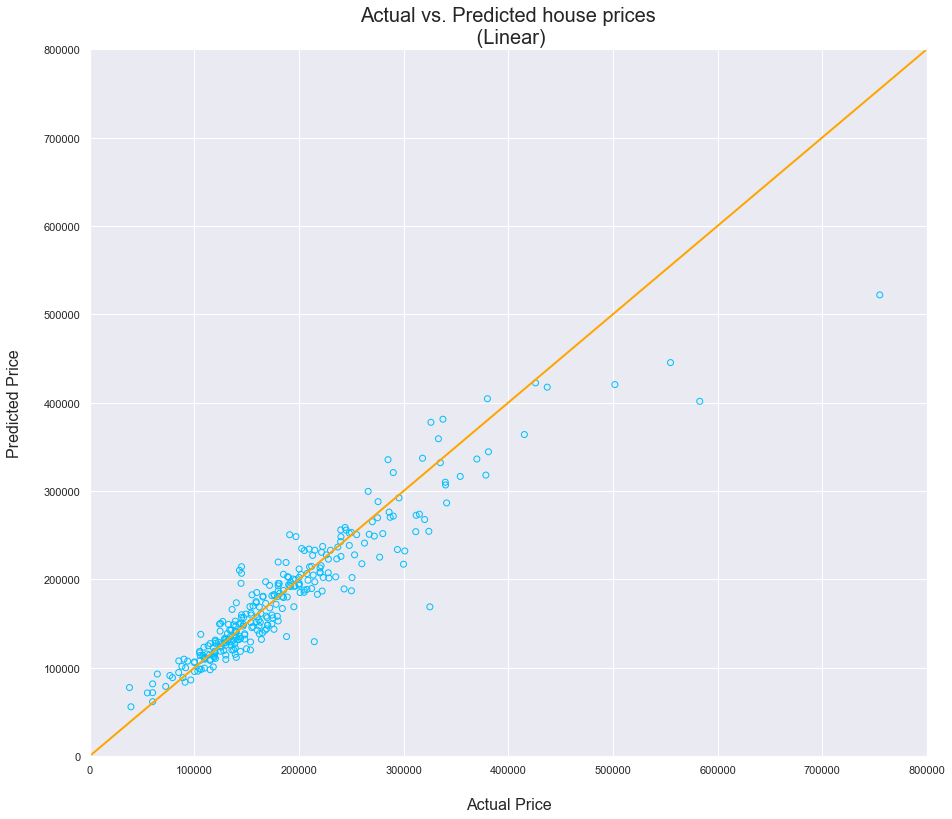

In [2951]:

scores_lin = cross_val_score(model_lin, X_train, y_train,
                 cv=5)

print("Mean scores (Linear Model):\n", np.mean(scores_lin))
print("Standard deviation of scores (Linear Model):\n", np.std(scores_lin))

model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
#print_score(y_test, y_pred_lin, "Linear")

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Linear)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lin),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

Mean scores (Lasso Model):
 0.8569706018948826
Standard deviation of scores (Lasso Model):
 0.053733809229809214
MSE scores (Lasso Model):
 [0.03445763 0.01682528 0.01821205 0.02027903 0.01755133]
Mean MSE scores: 0.021465063972984054


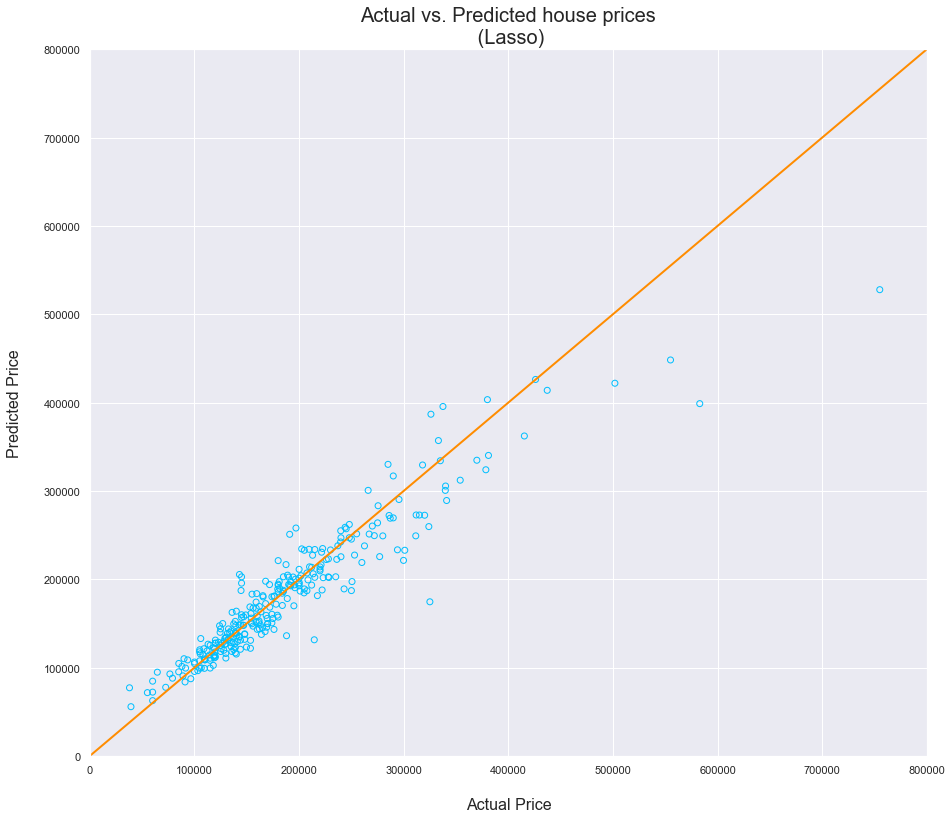

In [2952]:
scores_lasso = cross_val_score(model_lasso, X_train, y_train,
                                cv=5)

print("Mean scores (Lasso Model):\n", np.mean(scores_lasso))
print("Standard deviation of scores (Lasso Model):\n", np.std(scores_lasso))

scores_lasso_mse = -1 * cross_val_score(model_lasso, X_train, y_train,
                                      cv=5,
                                      scoring='neg_mean_squared_error')

print("MSE scores (Lasso Model):\n", scores_lasso_mse)
print("Mean MSE scores:", scores_lasso_mse.mean())


model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
#print_score(y_test, y_pred_lasso, "Lasso")


# Save the model results into lists
#model_list.append(model_lasso.__class__.__name__)
#r2_list.append(round(rsqr_score(y_test, y_pred_lasso), 4))
#rmse_list.append(round(rmse_score(y_test, y_pred_lasso), 4))


plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lasso),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()



prediction